<h1>Addressing Data Scarcity in Computer Vision<h1>

Semi-supervised learning, Few-shot, Zero-shot, and unsupervised learning: How not to label all your data.

## Semi-supervised Learning

Remember the course:

*   A lot of data in the dataset, but...
*   ... some labels are missing



We will use the pytorch tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py  and adapt it to semi-supervised learning.

We will use CIFAR10, a dataset of small images among 10 different classes.
The training set normally has 50 000 images and the test set 10 000.

This dataset is entirely annotated, so we will artificially remove some labels.


In [67]:
import torch
import torchvision
import torchvision.transforms as transforms


batch_size = 32

# we will keep only 40% of the dataset labelled.
# Feel free to try with another value.
prop_labelled_elements = 0.4
device = torch.device("cuda")

**Exercise**: What happens if this is very low? Very high? Run the experiments and report the results.

In [68]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_train = torchvision.datasets.CIFAR10("./data", download=True, train=True, transform=transform)
dataset_val = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


We start by splitting the training dataset between


*   labelled elements
*   unlabelled elements

Because our dataset is completely labelled, we artificially remove some labels and set them to -1.



In [69]:
import numpy as np

np.random.seed(0)  # for reproducibility
indices = np.arange(len(dataset_train))
np.random.shuffle(indices)  # mix the indices to not only keep the first N examples labelled.
n_labelled_indices = int(len(indices) * prop_labelled_elements)
indices_labelled = sorted(indices[:n_labelled_indices])
indices_unlabelled = sorted(indices[n_labelled_indices:])

for index in indices_unlabelled:
    dataset_train.targets[index] = -1  # artificially remove targets

dataset_train_labelled = torch.utils.data.Subset(dataset_train, indices_labelled)
dataset_train_unlabelled = torch.utils.data.Subset(dataset_train, indices_unlabelled)


In [70]:
train_loader_labelled = torch.utils.data.DataLoader(dataset_train_labelled, batch_size=batch_size, shuffle=True)
train_loader_unlabelled = torch.utils.data.DataLoader(dataset_train_unlabelled, batch_size=batch_size)  # No shuffle here, otherwise we won't be able to relabel properly.
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [71]:
import matplotlib.pyplot as plt


def imshow(img):
    """
    From a torch.Tensor to a matplotlib plot.
    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

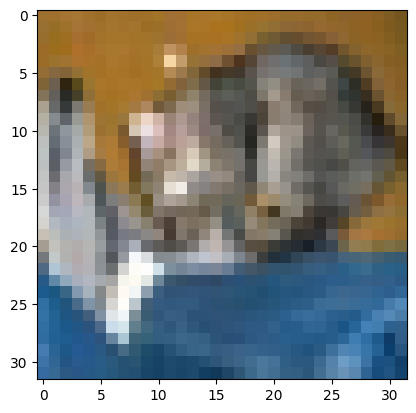

Class: cat


In [72]:
img, label = dataset_val[0]
imshow(img)
plt.show()
print("Class:", dataset_val.classes[label])

Here is a toy network we will be using.

**Exercise**: Try to improve performance by changing this model (e.g. by using a modern architecture like a ResNet). What happens if the network is pretrained? Not pretrained?

In [73]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Now we define the training, validation functions.

In [74]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook


def train(valloader, trainloader, model, opt, crit, n_epoch=2, loss_every=500):
    """
    Trains the model and plot the losses and accuracy curves.
    """
    model.train()
    losses = []
    acc = []
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        print(f"Epoch {epoch}.")

        running_loss = []
        running_acc = []
        print("Train.")
        for i, data in tqdm_notebook(enumerate(trainloader), total=len(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            opt.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            predicted = torch.argmax(outputs, dim=1)

            running_loss.append(loss.item())
            running_acc.append((predicted == labels).sum().item() / labels.size(0))

            # compute the running average
            if i % loss_every:
                losses.append(np.mean(running_loss))
                acc.append(np.mean(running_acc))

                running_loss = []
                running_acc = []

        print("Val.")
        val_acc = accuracy(valloader, model)
        print(f"Val accuracy: {val_acc}")
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(losses)
    axes[1].plot(acc)

    axes[0].set_ylabel("train loss")
    axes[1].set_ylabel("train acc")
    plt.show()
    print('Finished Training')


def accuracy(loader, model):
    """
    Args:
        loader: data loader to compute the accuracy over
        model: network
    Returns:
        Accuracy of the network over the data
    """
    with torch.no_grad():
        model.eval()  # remove potential dropout, ...
        n_correct = 0
        n_total = 0
        for i, data in tqdm_notebook(enumerate(loader), total=len(loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward + backward + optimize
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            n_correct += (predicted == labels).sum()
            n_total += labels.size(0)
        return n_correct / n_total


def validate(loader, model):
    """
    Plot some predictions of the model, print the accuracy.
    """
    dataiter = iter(loader)
    # Get one batch of data
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)

    accuracy_model = accuracy(loader, model)

    # print images
    print('Accuracy on test set:', accuracy_model.detach().cpu().item())

    imshow(torchvision.utils.make_grid(images[:4].cpu()))
    print('GroundTruth: ', ' '.join('%5s' % dataset_val.classes[labels[j]] for j in range(4)))
    print('Predicted: ', ' '.join('%5s' % dataset_val.classes[predicted[j]] for j in range(4)))



First, we will train a model only on the labelled train set.

In [75]:
import torch.optim as optim

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**Exercise:** Try different optimizer and lr.

Epoch 0.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.14919999241828918
Epoch 1.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.23799999058246613
Epoch 2.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.2816999852657318
Epoch 3.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.3337000012397766
Epoch 4.
Train.


  0%|          | 0/625 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.3901999890804291


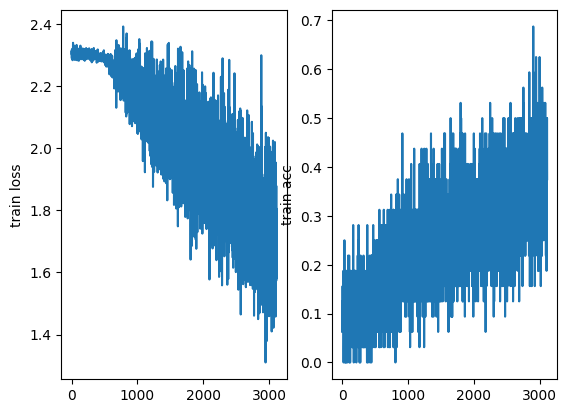

Finished Training


In [76]:
train(val_loader, train_loader_labelled, net, optimizer, criterion, n_epoch=5)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set: 0.3901999890804291


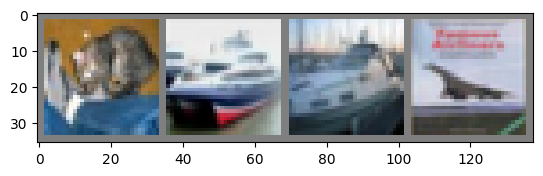

GroundTruth:    cat  ship  ship airplane
Predicted:    cat  ship  ship airplane


In [77]:
validate(val_loader, net)

Now let's predict the labels of the unlabelled set using our trained model.

In [78]:
def label_dataset(loader, model):
    """
    Returns:
        All the labels of the data in the loader predicted by the model.
        We will use this function to annotate the unlabelled data.
    """
    with torch.no_grad():
        model.eval()
        all_labels = []
        for i, data in tqdm_notebook(enumerate(loader), total=len(loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward + backward + optimize
            # COMPLETE HERE
            # define a variable `predicted` containing the labels of the current batch.
            # You can use the function `torch.argmax(values, dim)`.
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1) # TODO
            all_labels.append(predicted)
        return torch.cat(all_labels, dim=0)

In [79]:
labels = label_dataset(train_loader_unlabelled, net)

  0%|          | 0/938 [00:00<?, ?it/s]

In [80]:
print(labels)

tensor([6, 9, 1,  ..., 5, 8, 9], device='cuda:0')


And let's update the targets of the dataset to match the predicted labels.

In [81]:
for k, index in enumerate(indices_unlabelled):
    dataset_train.targets[index] = labels[k].detach().item()

Finally, let's retrain a model on the larger set with the predicted pseudo-labels.

In [88]:
net2 = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

Epoch 0.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.3105999827384949
Epoch 1.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.3780999779701233
Epoch 2.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.39800000190734863
Epoch 3.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.409199982881546
Epoch 4.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

Val.


  0%|          | 0/313 [00:00<?, ?it/s]

Val accuracy: 0.41839998960494995


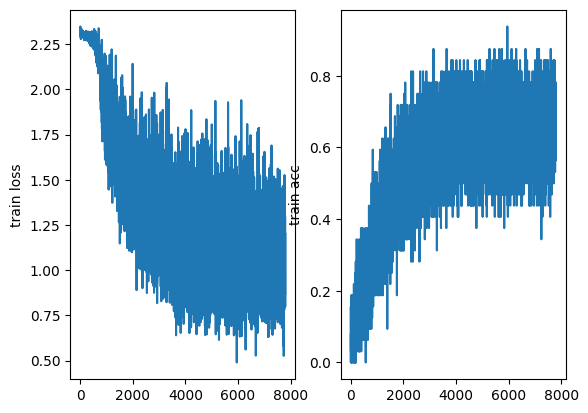

Finished Training


In [89]:
train(val_loader, train_loader, net2, optimizer, criterion, n_epoch=5)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set: 0.41839998960494995


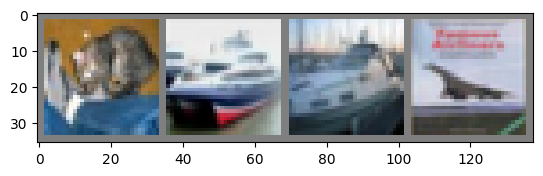

GroundTruth:    cat  ship  ship airplane
Predicted:    cat  ship  ship  ship


In [90]:
validate(val_loader, net2)

The accuracy should now be greater than for the first network!
The pseudo-labelling helped improving the accuracy!

**Question**: what would be the limit of accuracy that we could hope to achieve if the method was perfect? Try to compute it.

## Few-shot learning

We will see the metric learning approach and define a metric over 2 images.

We will continue to use CIFAR as our dataset.

Here we will look at 5-shot learning and select 5 examples per class.


In [32]:
import torch
import torchvision
import torchvision.transforms as transforms


batch_size = 32
# 5-shot learning
# try it out with other values. What happens if > 5? And < 5?
n_examples_per_class = 5
device = torch.device("cuda")

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_train = torchvision.datasets.CIFAR10("./data", download=True, train=True, transform=transform)
dataset_val = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Let's randomly select 5 images per class to represent the images of our class.


In [34]:
import numpy as np

np.random.seed(0)  # for reproducibility. Change this value to try different examples in the class
indices = np.arange(len(dataset_train))
np.random.shuffle(indices)

n_classes = len(dataset_train.classes)

prototypes = [[] for k in range(n_classes)]
done = []

for k in indices:
    img, label = dataset_train[k]
    if len(prototypes[label]) < n_examples_per_class:
        prototypes[label].append(img)
    if label not in done and len(prototypes[label]) == n_examples_per_class:
        done.append(label)
    if len(done) == n_classes:
        break

In [35]:
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [36]:
import matplotlib.pyplot as plt


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

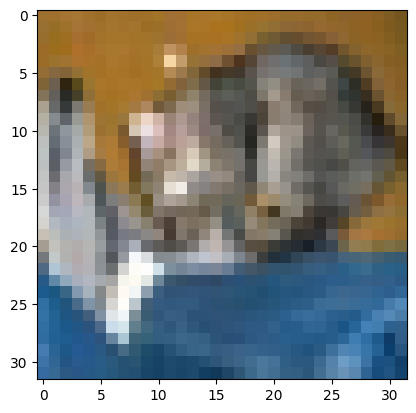

Class: cat


In [37]:
img, label = dataset_val[0]
imshow(img)
plt.show()
print("Class:", dataset_val.classes[label])

For the network, we will use a pretrained ResNet50.

In [38]:
from torchvision.models import resnet50
import torch.optim as optim
import torch.nn as nn

feature_net = resnet50(pretrained=True).to(device)
feature_net.fc = nn.Identity()  # remove the last layer to only get the feature vectors.

# We will not learn the model at all.
for param in feature_net.parameters():
    param.requires_grad_(False)

feature_net.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Now let's define the class prototypes by averaging the extracted features of the images of each class.

In [39]:
class_prototypes = []
for k in range(len(prototypes)):
    class_images = torch.stack(prototypes[k], dim=0).to(device)
    class_prototype = feature_net(class_images).mean(dim=0)  # get the features and average them
    class_prototype = class_prototype / class_prototype.norm(dim=-1, keepdim=True)  # normalize the vectors
    class_prototypes.append(class_prototype)
class_prototypes = torch.stack(class_prototypes, dim=0)

Now let's test the performance!

In [41]:
with torch.no_grad():
    n_correct = 0
    n_total = 0
    for i, data in tqdm_notebook(enumerate(val_loader), total=len(val_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = feature_net(inputs)
        # COMPLETE HERE
        # define `similarity` to be the dot product between outputs and class_prototypes.
        similarity = torch.matmul(outputs, class_prototypes.T) # TODO
        predicted = torch.argmax(similarity, dim=1)
        n_correct += (predicted == labels).sum()
        n_total += labels.size(0)
    accuracy = n_correct / n_total

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on val set:  0.36489999294281006


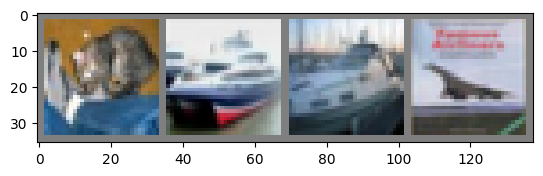

GroundTruth:    cat  ship  ship airplane
Predicted:    cat automobile truck automobile


In [46]:
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

features = feature_net(images)
features = features / features.norm(dim=-1, keepdim=True)
outputs = features @ class_prototypes.t()

predicted = torch.argmax(outputs, dim=1)

# print images
print("Accuracy on val set: ", accuracy.item())

imshow(torchvision.utils.make_grid(images[:4].cpu()))
print('GroundTruth: ', ' '.join('%5s' % dataset_val.classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % dataset_val.classes[predicted[j]] for j in range(4)))


## Zero-shot learning

For zero-shot learning, we will use the Animals with Attributes 2 dataset.

In [47]:
# Download the dataset...
!wget http://datasets.d2.mpi-inf.mpg.de/xian/xlsa17.zip
!unzip xlsa17.zip
!wget https://drive.google.com/uc?id=175VTyJROdAOrfccxJY7naRuLWrmJYRc8 -O animal_features.txt

--2024-10-23 08:25:25--  http://datasets.d2.mpi-inf.mpg.de/xian/xlsa17.zip
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.206.177
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.206.177|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.d2.mpi-inf.mpg.de/xian/xlsa17.zip [following]
--2024-10-23 08:25:25--  https://datasets.d2.mpi-inf.mpg.de/xian/xlsa17.zip
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.206.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 921803497 (879M) [application/zip]
Saving to: ‘xlsa17.zip’

xlsa17.zip          100%[===================>] 879.10M  22.9MB/s    in 42s     

2024-10-23 08:26:08 (20.7 MB/s) - ‘xlsa17.zip’ saved [921803497/921803497]

Archive:  xlsa17.zip
   creating: xlsa17/
   creating: xlsa17/code/
  inflating: xlsa17/code/ale_SUN_1e-1_50.mat  
  inflating: xlsa17/code/evaluate.m 

In [48]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [49]:
data_path = Path("/content/xlsa17/data")
awa_base_path = data_path / "AWA2"

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import random

device = torch.device('cuda')

We start by defining the datasets we will work on.

In [51]:
from scipy.io import loadmat


split = loadmat(awa_base_path / "att_splits.mat")
features = loadmat(awa_base_path / "res101.mat")

features, labels = features['features'], features['labels']

# Feature vectors
features = torch.from_numpy(features.T).to(device)
labels = torch.from_numpy(labels[:, 0]).to(device) - 1

classes = np.array([name[0].item() for name in split['allclasses_names']])
attributes = torch.from_numpy(split['att'].T).to(device, torch.float)
test_seen = split['test_seen_loc'][:, 0] - 1
test_unseen = split['test_unseen_loc'][:, 0] - 1
trainval = split['trainval_loc'][:, 0] - 1

attribute_names = np.array(['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic'])

In [52]:
print(f"Number of classes: {len(classes)}")
print(f"Size of attribute matrix: {attributes.shape}")

Number of classes: 50
Size of attribute matrix: torch.Size([50, 85])


In [53]:
print(features.shape)
print(labels.shape)

torch.Size([37322, 2048])
torch.Size([37322])


In [54]:
print(trainval.shape)  # only seen classes
print(test_seen.shape)
print(test_unseen.shape)

(23527,)
(5882,)
(7913,)


In [55]:
unseen_labels = list(set(labels[test_unseen.tolist()].tolist()))
seen_labels = list(set(labels[trainval.tolist()].tolist()))

torch_unseen_labels = torch.tensor(unseen_labels).long().to(device)
torch_seen_labels = torch.tensor(seen_labels).long().to(device)
torch_all_labels = labels.clone()

In [56]:
# Dataset will all vectors, the train and test set will be subset of this.
awa_dataset = torch.utils.data.TensorDataset(features.to(torch.float), labels.to(torch.long))
train_dataset = torch.utils.data.Subset(awa_dataset, trainval.tolist())
test_unseen_dataset = torch.utils.data.Subset(awa_dataset, test_unseen.tolist())
test_seen_dataset = torch.utils.data.Subset(awa_dataset, test_seen.tolist())

In [57]:
batch_size = 128

In [58]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_unseen_dataloader = torch.utils.data.DataLoader(test_unseen_dataset, batch_size)
test_seen_dataloader = torch.utils.data.DataLoader(test_seen_dataset, batch_size)

Some utility functions

In [59]:
def train(model, dataloader_train, dataloader_seen, dataloader_unseen,
          optimizer, n_epochs=10, unseen_bias=0, compute_train_acc=True,
          scheduler=None,
          verbose=True):
    for epoch in range(n_epochs):
        if verbose:
            print(f"Epoch {epoch+1}/{n_epochs}")
        acc = train_one_epoch(model, dataloader_train, optimizer, compute_train_acc)
        if verbose:
            print(f"Train step: Acc seen: {acc} ")
        acc_unseen = "n/a"
        if dataloader_seen is not None:
            total_correct_seen, total_seen = test_one_epoch(model, dataloader_seen, unseen_bias)
            acc_seen = total_correct_seen * 100. / float(total_seen)
        if dataloader_unseen is not None:
            total_correct_unseen, total_unseen = test_one_epoch(model, dataloader_unseen, unseen_bias)
            acc_unseen = total_correct_unseen * 100. / float(total_unseen)
        if acc_seen != "n/a" and acc_unseen != "n/a":
            acc_harmonic = 2 * acc_seen * acc_unseen / (acc_seen + acc_unseen)
        if verbose:
            print(f"Validation step: Acc seen: {acc_seen}, acc unseen: {acc_unseen}, harmonic average: {acc_harmonic}")
        if scheduler is not None:
            scheduler.step()
    return acc_seen, acc_unseen, acc_harmonic



def train_one_epoch(model, dataloader, optimizer, compute_train_acc):
    total_num_correct = 0
    total_elem = 0
    for feature_batch, label_batch in dataloader:
        optimizer.zero_grad()
        out = model(feature_batch)
        loss = model.loss(out, label_batch)
        if compute_train_acc:
            classification_scores = model.predict(out)
            _, prediction = torch.max(classification_scores, dim=1)
            total_num_correct += torch.sum(prediction == label_batch).tolist()
            total_elem += int(label_batch.size(0))
        loss.backward()
        optimizer.step()

    if total_elem == 0:
        return 'n/a'
    accuracy = total_num_correct * 100. / float(total_elem)
    return accuracy


def test_one_epoch(model, dataloader, unseen_bias):
    total_num_correct = 0
    total_elem = 0
    for feature_batch, label_batch in dataloader:
        out = model(feature_batch)
        loss = model.loss(out, label_batch)
        classification_scores = model.predict(out)
        prediction = model.prediction(classification_scores, unseen_bias)
        total_num_correct += torch.sum(prediction == label_batch).tolist()
        total_elem += int(label_batch.size(0))
    return total_num_correct, total_elem

In [60]:
def pca(features, classes, types, added_points=None, selected_classes=None, figsize=(20, 10), defining_attributes=True):
    # TODO: Initialize the PCA model with the desired number of components and apply it to the 'features' variable.
    pca_model = PCA(n_components=2) # Initialize PCA with n_components=2
    vectors_embedded_tsne = pca_model.fit_transform(features) # Apply PCA to the 'features' and get the transformed data
    components = pca_model.components_[:2]
    if defining_attributes:
        highest_indices = np.argsort(components, axis=1)[:, ::-1][:, :3]
        highest_values = np.sort(components, axis=1)[:, ::-1][:, :3]
        print("Defining attributes:\n", attribute_names[highest_indices])
        print("Value:\n", highest_values)
    if added_points is not None:
        added_features, added_classes, added_types = added_points
        added_points_projected = pca_model.transform(added_features)
        vectors_embedded_tsne = np.concatenate((vectors_embedded_tsne, added_points_projected), axis=0)
    else:
        added_classes = []
        added_types = []
    df_tsne = pd.DataFrame(vectors_embedded_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['Class'] = classes + added_classes
    df_tsne['Type'] = np.array(types + added_types)

    if selected_classes is None:
        selected_classes = classes

    df_tsne = df_tsne[df_tsne['Class'].isin(selected_classes)]
    n_classes = len(np.unique(df_tsne['Class']))

    plt.figure(figsize=figsize)
    #palette = sns.color_palette("hls", n_classes)
    palette = sns.color_palette("hls", len(np.unique(df_tsne['Type'])))
    ax = sns.scatterplot(data=df_tsne, x='Component 1', y='Component 2',
                         # hue='Class',
                         hue='Type',
                         palette=palette,
                         # style='Type',
                         legend='brief')

    for line in range(0, df_tsne.shape[0]):
        ax.text(df_tsne['Component 1'][line]+0.01, df_tsne['Component 2'][line],
                df_tsne['Class'][line], horizontalalignment='left',
                size='medium', color='black', weight='semibold')
    plt.show()

### Discover the attribute space

Defining attributes:
 [['big' 'water' 'swims']
 ['grazer' 'vegetation' 'hooves']]
Value:
 [[0.26231205 0.2563741  0.2459678 ]
 [0.28484714 0.2841431  0.2543024 ]]


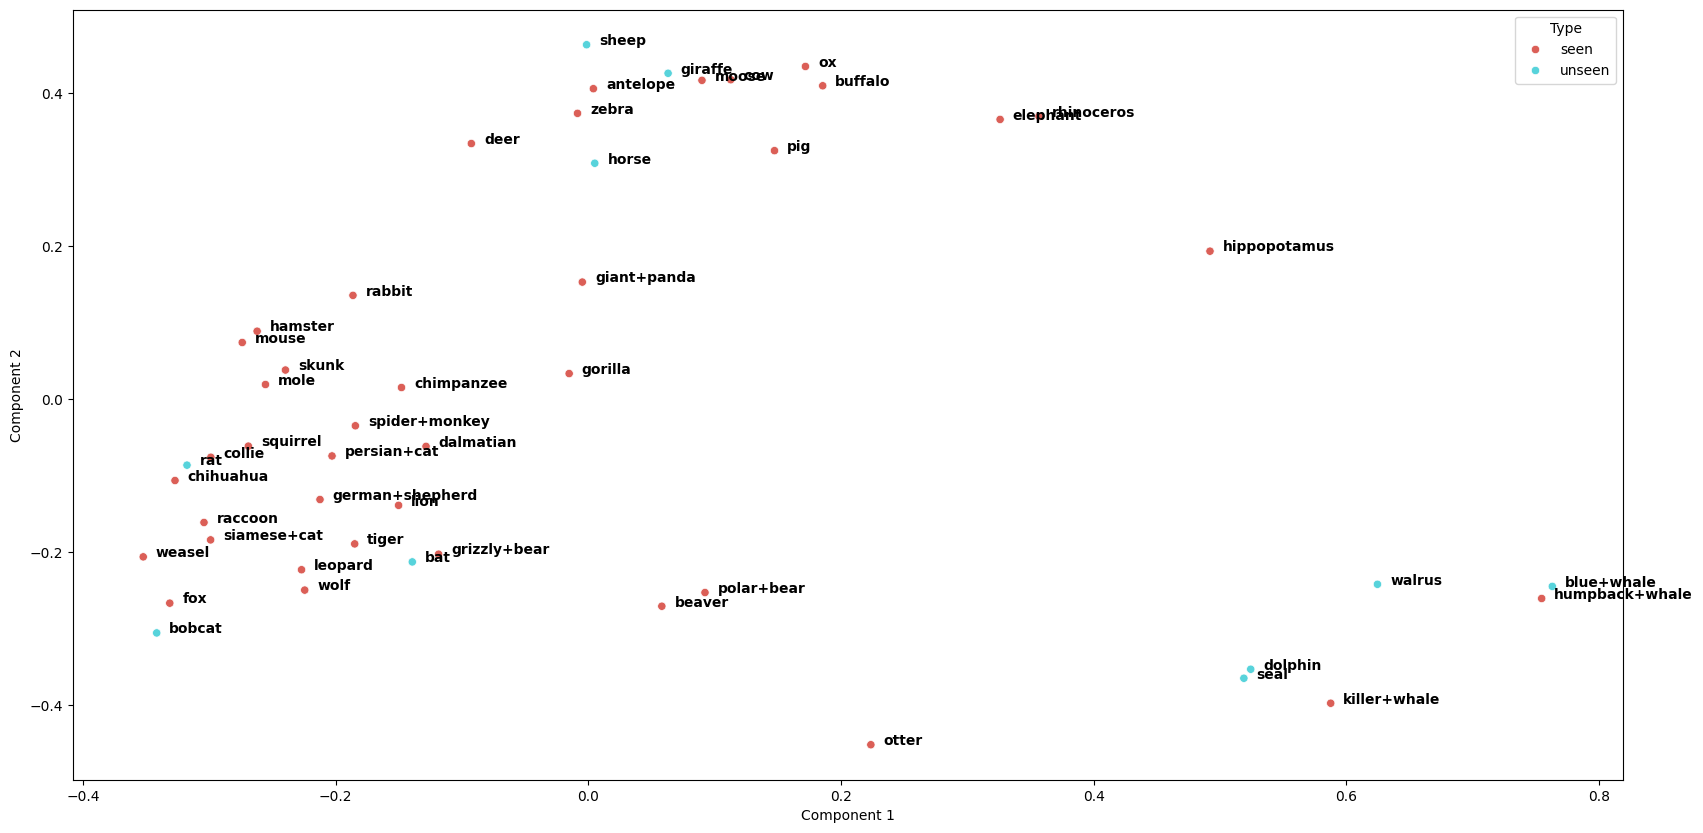

In [61]:
types = ['seen' if idx in seen_labels else 'unseen' for idx in range(len(classes))]

pca(attributes.cpu().numpy(), list(classes), types)

### With a linear compatibility function

Learn a projection from an **image** feature space to a **semantic** feature space.

$$F(x, y; W) = \theta(x)^T W \phi(y)$$

![image-linear-method](https://drive.google.com/uc?id=16UgDH0vfbv6SSxFzARjWzRoNT_EFJJLS)

#### DeViSE
[[A. Frome, G. S. Corrado, J. Shlens, S. Bengio, J. Dean, M. A.
Ranzato, and T. Mikolov. Devise: A deep visual-semantic
embedding model. In NIPS, 2013.]](https://www.cs.toronto.edu/~ranzato/publications/frome_nips2013.pdf)

Loss function: pairwise ranking objective
$$\sum_{y  \in \mathcal{Y}^{tr}}\max\left(0, 1_{y_n \ne y} + F(x_n, y; W) - F(x_n, y_n: W)\right)$$

In [62]:
def max_margin_loss(predictions, labels):
    len_denom = predictions.size(1) - 1
    margin = 1 - predictions.gather(1, labels.reshape(-1, 1)) + predictions
    zero = torch.tensor(0.).to(labels.device)
    # -1 to remove constant when pred[label] = pred[y]
    loss = torch.max(margin, zero).sum(dim=1) - 1
    return (loss / len_denom).mean()


class DeViSEClassification(nn.Module):
    def __init__(self, in_feature, semantic_vectors):
        super().__init__()

        # phi for each y.
        self.semantic_vectors = semantic_vectors

        # W matrix
        self.net = nn.Linear(in_feature, self.semantic_vectors.size(1), bias=False)

    def forward(self, features):
        """
        :param features: the theta vector
        """
        return self.net(features)  # theta^T * W

    def loss(self, predicted_semantic, labels):
        scores = self.predict(predicted_semantic)
        probabilities = torch.softmax(scores, dim=-1)
        return max_margin_loss(probabilities, labels)

    def predict(self, predicted_semantic):
        prediction = predicted_semantic @ self.semantic_vectors.transpose(1, 0)
        return prediction

    def prediction(self, classification_scores, bias):
        """
        Adds bias and return the predicted label for each input
        """
        classification_scores[:, seen_labels] -= bias
        _, prediction = torch.max(classification_scores, dim=1)
        return prediction

In [63]:
devise_model = DeViSEClassification(2048, attributes)
devise_model.to(device)
optimizer = torch.optim.Adam(devise_model.parameters())

In practice, we usually only test on the unseen val set.

It is complcated to make the models work on both seen and unseen images. Indeed, the model will more easily predict a seen class rather than an unseen one.

What is usually done is bias the unseen classes to artificially increase the prediction scores.

In [64]:

unseen_bias = 10

train(devise_model, train_dataloader,
      test_seen_dataloader, test_unseen_dataloader,
      optimizer,
      n_epochs=10,
      unseen_bias=unseen_bias)

Epoch 1/10
Train step: Acc seen: 80.90279253623497 
Validation step: Acc seen: 60.30261815708943, acc unseen: 55.3519524832554, harmonic average: 57.72132716184638
Epoch 2/10
Train step: Acc seen: 92.3449653589493 
Validation step: Acc seen: 72.52635158109487, acc unseen: 51.64918488563124, harmonic average: 60.33276840959758
Epoch 3/10
Train step: Acc seen: 93.7306073872572 
Validation step: Acc seen: 76.33458007480449, acc unseen: 53.102489574118536, harmonic average: 62.63362193785186
Epoch 4/10
Train step: Acc seen: 94.30441620266078 
Validation step: Acc seen: 80.12580754845291, acc unseen: 49.70302034626564, harmonic average: 61.349928323642025
Epoch 5/10
Train step: Acc seen: 95.20125812895822 
Validation step: Acc seen: 81.70690241414485, acc unseen: 46.720586376848225, harmonic average: 59.44824472955803
Epoch 6/10
Train step: Acc seen: 95.97483742083564 
Validation step: Acc seen: 83.11798707922475, acc unseen: 47.04915961076709, harmonic average: 60.08630503255547
Epoch 7/10

(88.4393063583815, 38.266144319474286, 53.41887412923248)

**Exercise:** try different values of `unseen_bias` What happens if the bias is low? if it is high?

## GANs

Not covered here.

See here for a notebook on GANs: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/e9c8374ecc202120dc94db26bf08a00f/dcgan_faces_tutorial.ipynb.